# Pricing cars

I want to be able to predict a car's market price using its attributes based on previous data. I'll be using the data described [here](https://archive.ics.uci.edu/ml/datasets/automobile) which can be downloaded [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data). I'm going to make a machine learning model that uses the k-nearest neighbors (knn) algorithm to predict prices based on the given data.

In [1]:
# Import the pandas library (for data analysis). 
import pandas as pd

# Avoid truncating number of columns displayed.
pd.options.display.max_columns = 100

# Create list of column names based on the data documentation.
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Read in the raw data.
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data', names=cols)

# Display the number of rows and columns and first five rows of data to explore.
print("This data set contains {} rows and {} columns.".format(cars.shape[0], cars.shape[1]))
cars.head().style.hide_index()

This data set contains 205 rows and 26 columns.


symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.600000,168.800000,64.100000,48.800000,2548,dohc,four,130,mpfi,3.47,2.68,9.000000,111,5000,21,27,13495
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.600000,168.800000,64.100000,48.800000,2548,dohc,four,130,mpfi,3.47,2.68,9.000000,111,5000,21,27,16500
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.500000,171.200000,65.500000,52.400000,2823,ohcv,six,152,mpfi,2.68,3.47,9.000000,154,5000,19,26,16500
2,164,audi,gas,std,four,sedan,fwd,front,99.800000,176.600000,66.200000,54.300000,2337,ohc,four,109,mpfi,3.19,3.40,10.000000,102,5500,24,30,13950
2,164,audi,gas,std,four,sedan,4wd,front,99.400000,176.600000,66.400000,54.300000,2824,ohc,five,136,mpfi,3.19,3.40,8.000000,115,5500,18,22,17450


## Target column: price

The k-nearest neighbors algorithm (knn) employs one or more features to make a prediction about a given target. Since the goal of this model is to predict a car's price, the target column of interest will be the `price` column. 

## Choosing features

To train the model, I'll need to pick which attributes to use from the dataset. The knn algorithm makes predictions by calculating the "distance" between a data point and the current observation of interest. Since this distance must be calculated, the attributes used to train the model must be numeric.

Of the 25 possible feature columns, 15 are explicitly numeric. Another two columns have numeric values written as strings. Double-checking with the documentation, there are 15 columns that represent continuous variables. These are the columns I'll be working with for this model.

In [2]:
# Create list of column names that have numeric variables.
num_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 
            'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 
            'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 
            'highway-mpg', 'price']

# Create a new dataframe using just the numeric columns.
num_cars = cars[num_cols].copy()

## Cleaning the data

Predictive modeling will fail if presented with any missing values. Using the `dataframe.info()` method (not shown in cells), there doesn't appear to be any missing values. However, there are missing values represented as "?" that can be seen in the preview above and that are found upon exploring other columns.

### Replacing values
I'll replace the "?" missing values with `numpy.nan` (a floating point representation of Not a Number) so that we may properly address the missing values.

In [3]:
# Import the numpy library (for computation).
import numpy as np

# Replace all "?" values in the dataset with "np.nan".
num_cars.replace('?', value=np.nan, inplace=True)

The "?" values in some of the columns resulted in pandas typing those columns as `object` instead of numbers (`int` or `float`). With the `np.nan` values in place, I can now convert those columns to number types.

In [4]:
# Convert the entire numeric dataframe to float type.
num_cars = num_cars.astype('float')

# Display dataframe information.
num_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    float64
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    float64
 6   engine-size        205 non-null    float64
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression-rate   205 non-null    float64
 10  horsepower         203 non-null    float64
 11  peak-rpm           203 non-null    float64
 12  city-mpg           205 non-null    float64
 13  highway-mpg        205 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 24.1 KB


The table above confirms that all columns are now float type. It also shows how many values each column contains.

### Addressing missing values

The `normalized-losses` column has the most missing values with 20% absent. This column represents the normalized average loss payment per car per year. Upon exploring the range and mean of this column's values, and given that 80% of the data is present, I've decided to replace the missing values with the mean value of the column.

Since the rest of the columns have only 2-4 missing values, I'll replace those with means as well.

The only data I will remove are the rows with missing `price` values, since without a `price`, I don't have data about the target.

In [5]:
# Drop the rows with missing price values.
num_cars.dropna(subset=['price'], inplace=True)

# Replace missing values in other columns with column means.
num_cars.fillna(num_cars.mean(), inplace=True)

# Check that there are no missing values remaining.
num_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

### Normalizing the data

To make sure that columns with larger ranges don't have a disproportionate impact on later calculations, I'm going to normalize all of the feature data such that all values range from `0` to `1`. Only the price values will remain as is.

This transformation is represented mathematically as the following equation:
$$x_{norm} = \frac{x_i- x_{min}}{x_{max} - x_{min}}  $$
where $x_i$ is a given value in a column, $x_{max}$ is the maximum value in that column, and $x_{min}$ is the minimum value in that column.

In [6]:
# Get list of columns to transform.
num_cols.remove('price')

# Create new dataframe to normalize.
num_cars_norm = num_cars[num_cols].copy()

# Normalize new dataframe.
num_cars_norm = (num_cars_norm - num_cars_norm.min()) / (num_cars_norm.max() - num_cars_norm.min())

# Add price column to new dataframe.
num_cars_norm['price'] = num_cars['price']

# Display first five rows of normalized dataframe.
num_cars_norm.head().style.hide_index()

normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125000,0.294393,0.346939,0.222222,0.289474,13495.000000
0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125000,0.294393,0.346939,0.222222,0.289474,16500.000000
0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.125000,0.495327,0.346939,0.166667,0.263158,16500.000000
0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.187500,0.252336,0.551020,0.305556,0.368421,13950.000000
0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.062500,0.313084,0.551020,0.138889,0.157895,17450.000000


## Univariate modeling

I'll start by using only one feature at a time to establish a workflow and gain a better understanding of the features.

In [7]:
# Import scikit-learn modules for knn algorithm and calculating mean squared error.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [8]:
# Create a function that trains the knn model and returns the root mean squared error.
def knn_train_test(feature_col, target_col, data, k=5):
    size = data.shape[0]
    split = int(0.8*size)
    train_data = data.iloc[:split]
    test_data = data.iloc[split:]
    
    knn = KNeighborsRegressor(k, algorithm='brute')
    knn.fit(train_data[[feature_col]], train_data[target_col])
    predictions = knn.predict(test_data[[feature_col]])
    mse = mean_squared_error(test_data[target_col], predictions)
    rmse = np.sqrt(mse)
    return rmse

In [9]:
# Train the algorithm with default k=5 on all numerical features. Add to list to sort.
k5_rmses = []
for col in num_cols:
    k5_rmses.append((knn_train_test(col, 'price', num_cars_norm), col))
    
# Display resulting root mean squared errors from best to worst.
sorted(k5_rmses)

[(2240.243368094789, 'curb-weight'),
 (3081.9965218954435, 'highway-mpg'),
 (3648.009180160678, 'engine-size'),
 (3784.53848125469, 'city-mpg'),
 (3925.525377173006, 'width'),
 (4366.884331296952, 'horsepower'),
 (5575.351951616171, 'compression-rate'),
 (6350.6655525228225, 'height'),
 (6712.899109813628, 'peak-rpm'),
 (6780.7906789839135, 'length'),
 (6845.884487528646, 'wheel-base'),
 (7739.0989402403475, 'bore'),
 (8882.08776012355, 'stroke'),
 (9544.266653707511, 'normalized-losses')]

### Varying k value

I'll return a dataframe of root-mean-squared values for the different `k` values for all of the individual numerical features. This will provide more information on how the model performs with the different features.

In [10]:
# Create a new dataframe.
rmses = pd.DataFrame([1,3,5,7,9])
rmses.columns = ['hyper_params']
rmses.set_index(rmses['hyper_params'], inplace=True)

# Calculate rmses for different k values and features and save to new dataframe.
for k in rmses['hyper_params']:
    for col in num_cols:
        rmses.loc[k,col] = int(knn_train_test(col, 'price', num_cars_norm, k))
rmses.drop('hyper_params', axis=1, inplace=True)

# Display all the root-mean-squared values.
rmses

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg
hyper_params,,,,,,,,,,,,,,
1,7602.0,6929.0,6970.0,9070.0,12430.0,4010.0,5673.0,9771.0,11427.0,6456.0,5389.0,11765.0,4188.0,4563.0
3,8495.0,5720.0,6079.0,5594.0,7998.0,2323.0,5085.0,12335.0,9116.0,5635.0,4664.0,11027.0,3682.0,4119.0
5,9544.0,6845.0,6780.0,3925.0,6350.0,2240.0,3648.0,7739.0,8882.0,5575.0,4366.0,6712.0,3784.0,3081.0
7,8517.0,5963.0,5979.0,3375.0,5357.0,2576.0,3512.0,7584.0,7300.0,5490.0,4324.0,5876.0,3783.0,2936.0
9,8873.0,5566.0,4957.0,3253.0,4705.0,2609.0,3368.0,6240.0,6302.0,5376.0,4041.0,5963.0,3780.0,2755.0


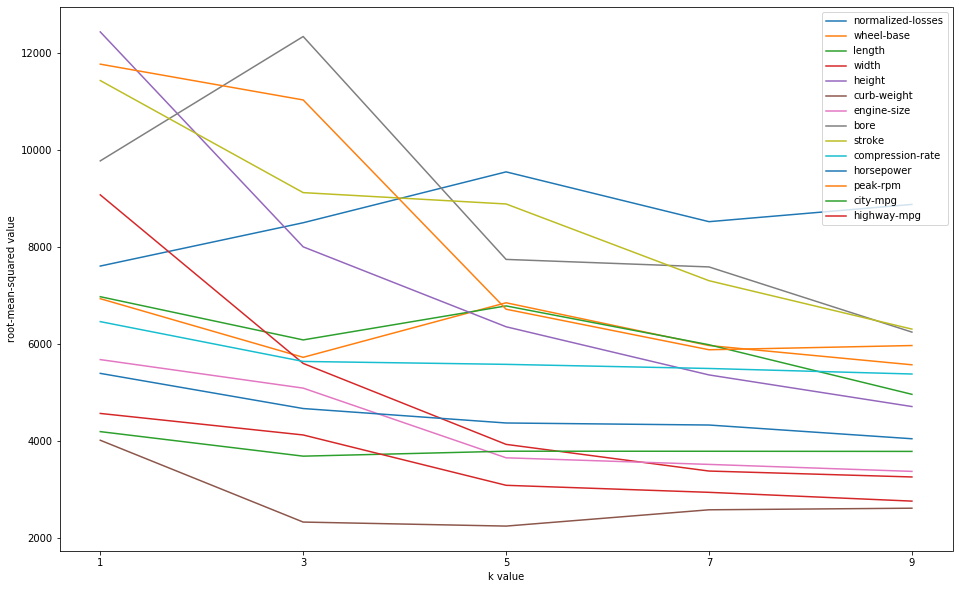

In [11]:
# Import matplotlib.pyplot to plot data.
import matplotlib.pyplot as plt

# Visualize the rmse values for each feature at different k values.
plt.figure(figsize=(16,10))
for col in rmses.columns:
    plt.plot(rmses.index, rmses[col])
plt.xticks([1,3,5,7,9])
plt.xlabel('k value')
plt.ylabel('root-mean-squared value')
plt.legend(rmses.columns)
plt.show()

In [12]:
# Return average rmse values for each feature and sort from best to worst.
sorted_rmse_means = rmses.mean().sort_values()
sorted_rmse_means

curb-weight          2751.6
highway-mpg          3490.8
city-mpg             3843.4
engine-size          4257.2
horsepower           4556.8
width                5043.4
compression-rate     5706.4
length               6153.0
wheel-base           6204.6
height               7368.0
peak-rpm             8268.6
stroke               8605.4
normalized-losses    8606.2
bore                 8733.8
dtype: float64

## Multivariate modeling

To train the model using multiple features, I'll make some slight modifications to my above function. The new function will take multiple feature columns as a parameter instead of just one. This will result in some minor logic changes throughout the function, but overall the workflow will remain the same.

In [13]:
# Modify the previous function to use multiple features.
def knn_train_test_multi(feature_cols, target_col, data, k=5):
    size = data.shape[0]
    split = int(0.8*size)
    train_data = data.iloc[:split]
    test_data = data.iloc[split:]
    
    knn = KNeighborsRegressor(k, algorithm='brute')
    knn.fit(train_data[feature_cols], train_data[target_col])
    predictions = knn.predict(test_data[feature_cols])
    mse = mean_squared_error(test_data[target_col], predictions)
    rmse = np.sqrt(mse)
    return rmse

In [14]:
# Train using best 2, 3, 4, and 5 features using k=5.
multi_rmses = {}
for num in range(2,6):
    multi_rmses[num] = knn_train_test_multi(list(sorted_rmse_means[:num].index), 'price', num_cars_norm)
multi_rmses

{2: 3212.942079898187,
 3: 2398.795185392745,
 4: 2342.325849944254,
 5: 2736.168788118374}

### Hyperparameter optimization - grid search

The top three models from the above cell used the top 4, 3, and 5 features. I'll now do a grid search to find the best hyperparameter `k` for each of the top three models.

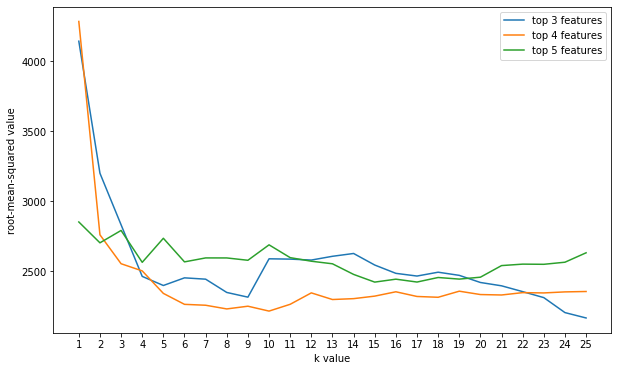

In [15]:
# Create a new dataframe.
top_3_grid_search = pd.DataFrame(range(1,26))
top_3_grid_search.columns = ['hyper_params']
top_3_grid_search.set_index(top_3_grid_search['hyper_params'], inplace=True)

for k in range(1,26):
    for num in range(3,6):
        top_3_grid_search.loc[k,num] = knn_train_test_multi(list(sorted_rmse_means[:num].index), 'price', num_cars_norm, k)
top_3_grid_search.drop('hyper_params', axis=1, inplace=True)
top_3_grid_search.columns = ['top 3 features', 'top 4 features', 'top 5 features']

# Visualize the rmse values for each model at different k values.
plt.figure(figsize=(10,6))
for col in top_3_grid_search.columns:
    plt.plot(top_3_grid_search.index, top_3_grid_search[col])
plt.xticks(range(1,26))
plt.xlabel('k value')
plt.ylabel('root-mean-squared value')
plt.legend(top_3_grid_search.columns)
plt.show()

In [16]:
# Find the optimal k values for each model.
top_3_grid_search.idxmin()

top 3 features    25
top 4 features    10
top 5 features    15
dtype: int64